In [1]:
import numpy as np
import pandas as pd
from pyGRNN import GRNN
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
"""
Function that loads and prepares the dataframe. 

Converts the data into time-series readable.
"""
def initialFormat (filepath, indicatorcode):
    #Reads the file and creates a dataframe from it
    df = pd.read_excel(filepath)
    
    #Choose what to forecast using indicator code
    df_icode = df.loc[df['Indicator Code'] == indicatorcode]
    
    #Dropping these columns as they are not needed for the forecast
    df_icode = df_icode.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    
    #Swap axis so it is in the proper format
    df_formatted = df_icode.swapaxes("index", "columns")
    
    #Renaming column name to 'values' to make reference easier
    for col_names in df_formatted.columns:
        name = df_formatted.rename(columns={col_names : "Val"})
        return name
    
    return df_formatted

In [4]:
"""
Refactored from: 

https://cprosenjit.medium.com/10-time-series-forecasting-methods-we-should-know-291037d2e285

"""

def shift_dataframe(data):
    #The value in "shift(-x)" is the lookback period in this case 1.
    data["Target"] = data.Val.shift(-1)
    data.dropna(inplace=True)
    
    return data

In [5]:
def train_test_split(data, test_size):
    
    train = data[:-test_size]
    test = data[-test_size:]
    
    return train, test

In [6]:
def mean_imputation(data):
    filled = data.fillna(data.mean())
    return filled

In [7]:
def grnn_model(train, X_test):
    train = np.asarray(train)
    
    X_train, y_train = train[:,0:1], train[:, -1]
    
    model = GRNN(kernel='RBF', n_splits=2, calibration='warm_start', seed = 42, sigma=1.97488702)
    model.fit(X_train, y_train)

    y_pred = model.predict(np.asarray([X_test]))
    
    return y_pred[0]

In [8]:
def walk_forward_validation(data, test_size):
    predictions = list()
    
    train, test = train_test_split(data, test_size)
    
    history = [x for x in train]
    
    for i in range(len(test)):
        
        X_test, y_test = test [i, :-1], test[i, -1]
        
        y_pred = grnn_model(history, X_test)
        
        predictions.append(y_pred)
    
    return test[:, -1], predictions

In [9]:
"""
Starting here is the hyperparameter optimisation for univariate forecasting

This piece of code was reused from https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

Fitted for my model
"""

def tune_n_estimator(X, y, X_test):
    
    params_IGRNN = {'kernel':["RBF"],
                'sigma' : list(np.arange(0.1, 4, 0.01)),
                'calibration' : ['None'], 'n_splits' : [2,5,10,15,20,25,30,len(X)]
                 }
    
    model = GRNN()
    
    grid_IGRNN = GridSearchCV(estimator=model,
                          param_grid=params_IGRNN,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1
                          )
    
    grid_IGRNN.fit(X, y)
    
    print("Best hyperparam: ", grid_IGRNN.best_params_)
    
    best_model = grid_IGRNN.best_estimator_
    y_pred = best_model.predict(X_test)
    
    return y_pred

In [10]:
def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)

In [11]:
data = initialFormat('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx', 
                     'NY.GDP.DEFL.KD.ZG')


In [12]:
filled = mean_imputation(data)
shifted = shift_dataframe(filled)

In [13]:
train, test = train_test_split(shifted.values, len(data) - int(len(data) * 0.8))

In [14]:
#actual, predicted = walk_forward_validation(shifted.values, len(data) - int(len(data) * 0.8))

In [15]:
X_train, y_train = train[:,0:1], train[:, -1]
X_test, y_test = test[: ,:-1], test[:, -1]

In [16]:
"""
From https://github.com/federhub/pyGRNN, the example of using GRNN. However this will be
adapted more in the future. This is only the start, so trying to see how GRNN works.

"""

IGRNN = GRNN()
params_IGRNN = {'kernel':["RBF"],
                'sigma' : list(np.arange(0.1, 4, 0.01)),
                'n_splits' : list(np.arange(2,len(X_train),1)),
                'calibration' : ['None']
                 }
grid_IGRNN = GridSearchCV(estimator=IGRNN,
                          param_grid=params_IGRNN,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1
                          )
grid_IGRNN.fit(X_train, y_train)

print("Best hyperparam: ", grid_IGRNN.best_params_)

best_model = grid_IGRNN.best_estimator_
y_pred = best_model.predict(X_test)





Fitting 5 folds for each of 17550 candidates, totalling 87750 fits
Best hyperparam:  {'calibration': 'None', 'kernel': 'RBF', 'n_splits': 2, 'sigma': 3.969999999999998}


In [17]:
#model = GRNN(kernel='RBF', n_splits=2, calibration='None', sigma='1.64999999')
#model.fit(X_train, y_train)

#y_pred = model.predict(X_test)

RMSE:  10.513711706838206
MAPE:  216.96584095190082
MAE:  9.560490953846939
Scatter Index:  129.12573181359116
MDA:  0.3333333333333333
Mean of actual:  8.14222816720686


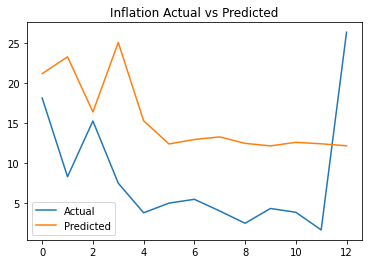

In [18]:
df_compare = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_pred})
df_compare.plot(title='Inflation Actual vs Predicted')
performance_metrics(y_test, y_pred)

In [19]:
df_compare

,Actual,Predicted
0,18.149751,21.201777
1,8.274752,23.312274
2,15.264294,16.394589
3,7.465943,25.108545
4,3.753879,15.295587
5,4.965990,12.382612
6,5.443175,12.944436
7,3.980243,13.266050
8,2.438924,12.461001
9,4.292678,12.143087
